# MNIST LAMBDA ANALYSIS

MNIST Lambda Analysis: Extending Differentiation Dynamics to Vision Tasks

This notebook adapts the λ measurement framework from the two moons toy problem
to MNIST digit classification. The key challenge is that MNIST lives in 784-dimensional
space (28x28 images) rather than 2D, so computing directional derivatives requires
careful sampling and the computational cost is higher. We'll run similar experiments:
correlation analysis, regularization sweeps, and training dynamics tracking.

### Setup and Data Initialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms
import time
from dataclasses import dataclass
from typing import List, Tuple, Dict
from scipy.stats import pearsonr

# ============================================================================
# Setup and Data Loading
# ============================================================================

def set_seed(s=0):
    """Ensure reproducibility across all random number generators"""
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_mnist(train_size=5000, test_size=1000, label_noise=0.0, seed=0):
    """
    Load MNIST with optional label noise and size restrictions.

    For computational efficiency, we use subsets of MNIST rather than the full
    60K/10K split. This speeds up experiments while preserving the essential
    characteristics of the dataset. Label noise is added by randomly flipping
    a fraction of training labels to incorrect classes.

    Args:
        train_size: Number of training examples to use
        test_size: Number of test examples to use
        label_noise: Fraction of training labels to randomly corrupt (0 to 1)
        seed: Random seed for reproducibility

    Returns:
        train_loader, test_loader: PyTorch DataLoaders
    """
    set_seed(seed)

    # Standard MNIST normalization to mean 0, std 1
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load full datasets
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    # Create subsets for efficiency
    train_indices = torch.randperm(len(train_dataset))[:train_size]
    test_indices = torch.randperm(len(test_dataset))[:test_size]

    train_subset = Subset(train_dataset, train_indices)
    test_subset = Subset(test_dataset, test_indices)

    # Add label noise if requested
    if label_noise > 0:
        # Extract the actual data and labels from the subset
        X_train = torch.stack([train_dataset[i][0] for i in train_indices])
        y_train = torch.tensor([train_dataset[i][1] for i in train_indices])

        # Randomly flip labels
        n_flip = int(label_noise * len(y_train))
        flip_idx = torch.randperm(len(y_train))[:n_flip]

        # For each flipped example, choose a random wrong class
        for idx in flip_idx:
            old_label = y_train[idx].item()
            # Choose from the 9 other classes
            new_label = old_label
            while new_label == old_label:
                new_label = torch.randint(0, 10, (1,)).item()
            y_train[idx] = new_label

        # Create new dataset with corrupted labels
        train_subset = TensorDataset(X_train, y_train)

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=512, shuffle=False)

    return train_loader, test_loader

Using device: cuda


### Model Architecture

In [3]:
class MNISTConvNet(nn.Module):
    """
    Simple CNN for MNIST classification.

    Architecture:
    - Conv 1: 1 -> 32 channels, 3x3 kernel
    - Conv 2: 32 -> 64 channels, 3x3 kernel
    - FC 1: 9216 -> 128 hidden units
    - FC 2: 128 -> 10 output classes

    We use ReLU activations throughout, which are smooth almost everywhere
    (except at zero) and commonly used in practice. MaxPool provides translation
    invariance. Dropout helps with regularization in the baseline.
    """
    def __init__(self, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(9216, 128)  # After two 2x2 maxpools: 28->24->12->10->5, so 64*5*5=1600... wait let me recalculate
        # Input: 28x28 -> Conv3x3 -> 26x26 -> MaxPool2x2 -> 13x13 -> Conv3x3 -> 11x11 -> MaxPool2x2 -> 5x5
        # So: 64 * 5 * 5 = 1600, not 9216. Let me fix this.
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)  # [B, 1, 28, 28] -> [B, 32, 26, 26]
        x = F.relu(x)
        x = self.conv2(x)  # [B, 32, 26, 26] -> [B, 64, 24, 24]
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # [B, 64, 24, 24] -> [B, 64, 12, 12]
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # [B, 64, 12, 12] -> [B, 9216]
        x = self.fc1(x)  # [B, 9216] -> [B, 128]
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)  # [B, 128] -> [B, 10]
        return x

### Lambda Estimation for High-Dimensional Inputs

In [4]:
def sample_image_directions(B, shape=(1, 28, 28)):
    """
    Sample random unit directions in image space.

    For MNIST, inputs are 784-dimensional (1 x 28 x 28). We sample Gaussian
    random directions and normalize them to unit length. These represent
    random perturbation directions in pixel space.

    Args:
        B: Batch size (number of directions to sample)
        shape: Image shape (channels, height, width)

    Returns:
        Tensor of shape [B, C, H, W] containing unit-norm random directions
    """
    U = torch.randn(B, *shape, device=device)
    # Flatten to compute norms, then reshape back
    U_flat = U.view(B, -1)
    norms = U_flat.norm(dim=1, keepdim=True)
    U_flat = U_flat / (norms + 1e-12)
    return U_flat.view(B, *shape)

def nth_dir_derivs_loss_images(model, X, y, U, n_max=4):
    """
    Compute nth directional derivatives of cross-entropy loss for images.

    This is adapted from the two moons version but handles the higher dimensionality
    of image inputs. The key difference is that X has shape [B, C, H, W] rather
    than [B, d], but the derivative computation logic remains the same.

    Args:
        model: Neural network
        X: Input images [B, C, H, W]
        y: True labels [B]
        U: Unit direction vectors [B, C, H, W]
        n_max: Maximum derivative order to compute

    Returns:
        List of tensors, each [B], containing nth derivatives for n=1..n_max
    """
    X = X.clone().detach().to(device).requires_grad_(True)
    y = y.clone().detach().to(device)
    U = U.clone().detach().to(device)

    # Forward pass and loss computation
    logits = model(X)
    loss_i = F.cross_entropy(logits, y, reduction='none')
    y_scalar = loss_i.sum()

    out = []

    for _ in range(1, n_max+1):
        # Compute gradient of scalar with respect to inputs
        grads = torch.autograd.grad(y_scalar, X, create_graph=True, retain_graph=True)[0]

        # Project onto directional vectors and sum across spatial dimensions
        # grads: [B, C, H, W], U: [B, C, H, W]
        # We want dot product for each example in the batch
        d_n = (grads * U).view(grads.size(0), -1).sum(dim=1)  # [B]

        out.append(d_n.clone())

        # Prepare for next iteration
        y_scalar = d_n.sum()

    return out

def estimate_lambda_mnist(model, data_loader, n_max=4, K_dirs=2, max_batches=5):
    """
    Estimate λ on MNIST data.

    Unlike two moons where we focused on boundary points, MNIST has 10 classes
    and a more complex decision boundary. We can either:
    1. Sample uniformly from the test set
    2. Focus on low-confidence predictions (near boundaries)

    For simplicity, we'll sample uniformly but limit the number of batches
    for computational efficiency.

    Args:
        model: Trained neural network
        data_loader: DataLoader for test data
        n_max: Maximum derivative order
        K_dirs: Number of random directions per example
        max_batches: Maximum number of batches to process (for speed)

    Returns:
        lambda_estimate: Scalar λ value
        fitting_data: Tuple of (orders, log_norms, intercept) for plotting
    """
    model.eval()
    eps = 1e-12
    logs = [[] for _ in range(n_max)]

    with torch.enable_grad():
        for batch_idx, (X, y) in enumerate(data_loader):
            if batch_idx >= max_batches:
                break

            X, y = X.to(device), y.to(device)
            B = X.size(0)

            # Sample multiple random directions per example
            for _ in range(K_dirs):
                U = sample_image_directions(B, shape=(1, 28, 28))

                # Compute directional derivatives
                d_list = nth_dir_derivs_loss_images(model, X, y, U, n_max=n_max)

                # Store log of absolute values
                for n, d_n in enumerate(d_list):
                    logs[n].append(torch.log(torch.clamp(d_n.abs(), min=eps)).detach().cpu())

    # Aggregate across all batches and directions
    y = np.array([torch.cat(logs[n]).mean().item() for n in range(n_max)])
    ns = np.arange(1, n_max+1, dtype=float)

    # Fit line: y = beta + alpha * n
    A = np.column_stack([np.ones_like(ns), ns])
    beta, alpha = np.linalg.lstsq(A, y, rcond=None)[0]

    return float(alpha), (ns, y, beta)

### Lambda Regularization for Images

In [5]:
def lambda_regularizer_images(model, X_reg, y_reg, start_n=1, end_n=3, K_dirs=2, scale=1e-3):
    """
    Compute curvature rate regularization (CRR) penalty for image inputs.

    This function penalizes high-order directional derivatives of the loss function,
    allowing flexible specification of which derivative orders to include.

    Args:
        model: Neural network
        X_reg: Regularization batch images [B, C, H, W]
        y_reg: Labels for regularization batch [B]
        start_n: Starting derivative order to penalize (default: 1)
        end_n: Ending derivative order to penalize (default: 3)
        K_dirs: Number of random directions to sample per iteration (default: 2)
        scale: Regularization strength multiplier (default: 1e-3)

    Returns:
        Scalar regularization loss averaged across orders [start_n, end_n]

    Example:
        # Regularize only 2nd through 4th order derivatives
        loss_reg = lambda_regularizer_images(model, X, y, start_n=2, end_n=4, scale=0.1)

        # Regularize only 1st order (similar to standard gradient penalty)
        loss_reg = lambda_regularizer_images(model, X, y, start_n=1, end_n=1, scale=1.0)
    """

    # CRITICAL: Save training state and switch to eval mode
    # This freezes dropout so we get consistent, deterministic derivatives
    was_training = model.training
    model.eval()

    # Input validation
    if start_n < 1:
        raise ValueError(f"start_n must be >= 1, got {start_n}")
    if end_n < start_n:
        raise ValueError(f"end_n ({end_n}) must be >= start_n ({start_n})")

    X_reg = X_reg.to(device).requires_grad_(True)
    y_reg = y_reg.to(device)

    reg_terms = []

    # Build computation graph through loss
    logits = model(X_reg)
    loss_i = F.cross_entropy(logits, y_reg, reduction='none')
    y_scalar = loss_i.sum()

    # Compute derivatives sequentially from 1 to end_n
    for n in range(1, end_n + 1):
        grads = torch.autograd.grad(y_scalar, X_reg, create_graph=True, retain_graph=True)[0]
        U = sample_image_directions(X_reg.size(0), shape=(1, 28, 28))
        d_n = (grads * U).view(grads.size(0), -1).sum(dim=1)

        # Only penalize if n is in the requested range
        if n >= start_n:
            reg_terms.append(d_n.abs().mean())

        # Prepare for next derivative order
        y_scalar = d_n.sum()

    # Restore original training state
    if was_training:
        model.train()

    if len(reg_terms) == 0:
        return torch.tensor(0.0, device=device)

    return scale * torch.stack(reg_terms).mean()

### Evaluation Functions

In [6]:
def compute_expected_calibration_error(model, test_loader, n_bins=10):
    """
    Compute Expected Calibration Error (ECE).

    ECE measures how well predicted probabilities match actual correctness rates.
    Lower is better.

    Args:
        model: Trained neural network
        test_loader: DataLoader for test data
        n_bins: Number of bins for probability discretization

    Returns:
        ece: Expected Calibration Error (scalar)
    """
    model.eval()

    all_probs = []
    all_correct = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)

            # Get max probability and whether prediction was correct
            max_probs, preds = probs.max(dim=1)
            correct = (preds == labels).float()

            all_probs.extend(max_probs.cpu().numpy())
            all_correct.extend(correct.cpu().numpy())

    all_probs = np.array(all_probs)
    all_correct = np.array(all_correct)

    # Bin the predictions
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find predictions in this bin
        in_bin = (all_probs > bin_lower) & (all_probs <= bin_upper)
        prop_in_bin = in_bin.mean()

        if prop_in_bin > 0:
            accuracy_in_bin = all_correct[in_bin].mean()
            avg_confidence_in_bin = all_probs[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return float(ece)


def compute_hard_sample_accuracy(model, test_loader, percentile=20):
    """
    Compute accuracy on the hardest samples (lowest confidence predictions).

    Args:
        model: Trained neural network
        test_loader: DataLoader for test data
        percentile: Consider bottom X% as "hard" samples

    Returns:
        hard_acc: Accuracy on hard samples
    """
    model.eval()

    all_confidences = []
    all_correct = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)

            max_probs, preds = probs.max(dim=1)
            correct = (preds == labels).float()

            all_confidences.extend(max_probs.cpu().numpy())
            all_correct.extend(correct.cpu().numpy())

    all_confidences = np.array(all_confidences)
    all_correct = np.array(all_correct)

    # Find threshold for bottom percentile
    threshold = np.percentile(all_confidences, percentile)

    # Get accuracy on hard samples
    hard_mask = all_confidences <= threshold
    if hard_mask.sum() > 0:
        hard_acc = all_correct[hard_mask].mean()
    else:
        hard_acc = 0.0

    return float(hard_acc)


def compute_confusion_matrix(model, test_loader, num_classes=10):
    """
    Compute confusion matrix for all classes.

    Returns:
        confusion: [num_classes, num_classes] numpy array
                  confusion[i,j] = # of samples with true label i predicted as j
    """
    model.eval()
    confusion = np.zeros((num_classes, num_classes), dtype=np.int32)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)

            for true_label, pred_label in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                confusion[true_label, pred_label] += 1

    return confusion


def compute_pair_confusion_rate(confusion_matrix, class_a, class_b):
    """
    Compute confusion rate between two specific classes.

    Confusion rate = (# of a->b misclassifications + # of b->a misclassifications) /
                     (total # of class a + total # of class b)

    Args:
        confusion_matrix: Full confusion matrix
        class_a, class_b: Two classes to examine

    Returns:
        confusion_rate: Fraction of samples confused between these classes
    """
    # Total samples for each class
    total_a = confusion_matrix[class_a, :].sum()
    total_b = confusion_matrix[class_b, :].sum()

    # Misclassifications
    a_as_b = confusion_matrix[class_a, class_b]
    b_as_a = confusion_matrix[class_b, class_a]

    if total_a + total_b > 0:
        confusion_rate = (a_as_b + b_as_a) / (total_a + total_b)
    else:
        confusion_rate = 0.0

    return float(confusion_rate)


def extract_boundary_samples(test_loader, model, class_a, class_b,
                             prob_min=0.45, prob_max=0.55, max_samples=500):
    """
    Extract samples near the decision boundary between two classes.

    These are samples where the model is uncertain between class_a and class_b.

    Args:
        test_loader: DataLoader for test data
        model: Trained neural network
        class_a, class_b: Two classes to examine
        prob_min, prob_max: Probability range for boundary definition
        max_samples: Maximum number of samples to return

    Returns:
        boundary_images: Tensor of images near boundary
        boundary_labels: Tensor of true labels
    """
    model.eval()

    boundary_images = []
    boundary_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Only consider samples from these two classes
            mask = (labels == class_a) | (labels == class_b)
            if not mask.any():
                continue

            filtered_images = images[mask]
            filtered_labels = labels[mask]

            # Get probabilities
            logits = model(filtered_images)
            probs = F.softmax(logits, dim=1)

            # Get probability for the predicted class
            max_probs, _ = probs.max(dim=1)

            # Find samples in boundary region
            boundary_mask = (max_probs >= prob_min) & (max_probs <= prob_max)

            if boundary_mask.any():
                boundary_images.append(filtered_images[boundary_mask])
                boundary_labels.append(filtered_labels[boundary_mask])

            # Stop if we have enough samples
            if len(boundary_images) > 0:
                total = sum(x.size(0) for x in boundary_images)
                if total >= max_samples:
                    break

    if len(boundary_images) == 0:
        # Return empty tensors with correct shape
        return torch.zeros((0, 1, 28, 28), device=device), torch.zeros((0,), dtype=torch.long, device=device)

    boundary_images = torch.cat(boundary_images, dim=0)[:max_samples]
    boundary_labels = torch.cat(boundary_labels, dim=0)[:max_samples]

    return boundary_images, boundary_labels


def estimate_lambda_for_pair(model, test_loader, class_a, class_b, n_max=4, K_dirs=2):
    """
    Estimate λ specifically for the boundary between two classes.

    Args:
        model: Trained neural network
        test_loader: DataLoader for test data
        class_a, class_b: Two classes to examine
        n_max: Maximum derivative order
        K_dirs: Number of random directions per example

    Returns:
        lambda_estimate: Scalar λ value for this class pair
    """
    # Extract boundary samples
    boundary_images, boundary_labels = extract_boundary_samples(
        test_loader, model, class_a, class_b,
        prob_min=0.40, prob_max=0.60, max_samples=200
    )

    if boundary_images.size(0) == 0:
        print(f"  Warning: No boundary samples found for classes {class_a}/{class_b}")
        return 0.0

    model.eval()
    eps = 1e-12
    logs = [[] for _ in range(n_max)]

    with torch.enable_grad():
        # Process in smaller batches if needed
        batch_size = 32
        for i in range(0, boundary_images.size(0), batch_size):
            X = boundary_images[i:i+batch_size]
            y = boundary_labels[i:i+batch_size]
            B = X.size(0)

            # Sample multiple random directions per example
            for _ in range(K_dirs):
                U = sample_image_directions(B, shape=(1, 28, 28))

                # Compute directional derivatives
                d_list = nth_dir_derivs_loss_images(model, X, y, U, n_max=n_max)

                # Store log of absolute values
                for n, d_n in enumerate(d_list):
                    logs[n].append(torch.log(torch.clamp(d_n.abs(), min=eps)).detach().cpu())

    # Aggregate and fit
    y = np.array([torch.cat(logs[n]).mean().item() for n in range(n_max)])
    ns = np.arange(1, n_max+1, dtype=float)

    # Fit line: y = beta + alpha * n
    A = np.column_stack([np.ones_like(ns), ns])
    beta, alpha = np.linalg.lstsq(A, y, rcond=None)[0]

    return float(alpha)

### Training Functions

In [7]:
def train_mnist_model(
    train_loader,
    test_loader,
    epochs=10,
    lambda_reg=False,
    lambda_scale=1e-3,
    Nreg=3,
    lr=1e-3,
    seed=0
):
    """
    Train MNIST model with optional λ regularization.

    Args:
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        epochs: Number of training epochs
        lambda_reg: Whether to apply λ regularization
        lambda_scale: Strength of λ penalty
        Nreg: Maximum derivative order for regularization
        lr: Learning rate
        seed: Random seed

    Returns:
        model: Trained model
        test_acc: Final test accuracy
        history: Dict with training metrics over time
    """
    set_seed(seed)

    model = MNISTConvNet(dropout=0.5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'test_acc': [], 'test_loss': []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(X_batch)
            loss = F.cross_entropy(logits, y_batch)

            # Add λ regularization if enabled
            if lambda_reg:
                # Use small subset for efficiency (derivatives are expensive)
                if X_batch.size(0) > 32:
                    sel = torch.randperm(X_batch.size(0))[:32]
                    X_reg, y_reg = X_batch[sel].detach(), y_batch[sel].detach()
                else:
                    X_reg, y_reg = X_batch.detach(), y_batch.detach()

                lreg = lambda_regularizer_images(model, X_reg, y_reg,
                                start_n=1, end_n=3, K_dirs=2, scale=lambda_scale)
                loss = loss + lreg

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                test_loss += F.cross_entropy(logits, y_batch, reduction='sum').item()
                pred = logits.argmax(dim=1)
                correct += (pred == y_batch).sum().item()
                total += y_batch.size(0)

        test_acc = correct / total
        test_loss = test_loss / total
        train_loss = train_loss / len(train_loader)

        history['train_loss'].append(train_loss)
        history['test_acc'].append(test_acc)
        history['test_loss'].append(test_loss)

        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, test_acc={test_acc:.4f}")

    return model, test_acc, history

### Experiment 1 - Correlation Analysis

In [8]:
@dataclass
class MNISTResult:
    """Store comprehensive results from one MNIST training run"""
    label_noise: float
    lambda_scale: float
    seed: int
    test_acc: float
    test_error: float
    lambda_est: float
    ece: float = 0.0
    hard_20_acc: float = 0.0
    confusion_49: float = 0.0
    confusion_38: float = 0.0
    confusion_67: float = 0.0
    lambda_49: float = 0.0
    lambda_38: float = 0.0
    lambda_67: float = 0.0

def experiment_mnist_correlation(n_seeds=5, label_noise_levels=[0.0, 0.2, 0.4]):
    """
    Test correlation between λ and generalization across label noise conditions.

    Similar to the two moons experiment, but we expect this to take longer due
    to higher dimensionality. We use fewer seeds for computational efficiency.

    Args:
        n_seeds: Number of random seeds per condition
        label_noise_levels: List of label noise fractions to test

    Returns:
        results: List of MNISTResult objects
        correlation: Pearson (r, p) tuple
    """
    print("\n" + "="*70)
    print("MNIST Experiment 1: Correlation Analysis")
    print("="*70)

    results = []

    for label_noise in label_noise_levels:
        print(f"\nTesting label_noise={label_noise:.2f}")

        for seed in range(n_seeds):
            print(f"  Seed {seed+1}/{n_seeds}...", end=" ")

            # Load data with noise
            train_loader, test_loader = load_mnist(
                train_size=5000,
                test_size=1000,
                label_noise=label_noise,
                seed=seed
            )

            # Train model
            model, test_acc, history = train_mnist_model(
                train_loader, test_loader,
                epochs=10,
                lambda_reg=False,
                seed=seed+1000
            )

            # Estimate λ
            lambda_est, _ = estimate_lambda_mnist(
                model, test_loader,
                n_max=4, K_dirs=2, max_batches=3
            )

            result = MNISTResult(
                label_noise=label_noise,
                lambda_scale=0.0,
                seed=seed,
                test_acc=test_acc,
                test_error=1.0 - test_acc,
                lambda_est=lambda_est
            )
            results.append(result)

            print(f"acc={test_acc:.3f}, λ={lambda_est:.3f}")

    # Compute correlation
    test_errors = np.array([r.test_error for r in results])
    lambdas = np.array([r.lambda_est for r in results])
    r, p = pearsonr(test_errors, lambdas)

    print(f"\nPearson correlation(test_error, λ) = {r:.3f} (p={p:.3g})")

    # Plot
    plt.figure(figsize=(8, 6))
    colors = {0.0: 'blue', 0.2: 'orange', 0.4: 'red'}
    for label_noise in label_noise_levels:
        subset = [r for r in results if r.label_noise == label_noise]
        te = [r.test_error for r in subset]
        lam = [r.lambda_est for r in subset]
        plt.scatter(lam, te, c=colors.get(label_noise, 'gray'),
                   label=f'noise={label_noise:.1f}', alpha=0.7, s=50)

    plt.xlabel('λ estimate', fontsize=12)
    plt.ylabel('Test Error', fontsize=12)
    plt.title(f'MNIST: Test Error vs λ\n(r={r:.3f}, p={p:.3g})', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return results, (r, p)


### Experiment 2 - Regularization Sweep

In [9]:
def experiment_mnist_reg_sweep(
    scales=[0.0, 0.01, 0.1, 1, 10, 100, 200],
    label_noise=0.0,  # Changed default to 0.0 for "practical effects"
    n_seeds=5,
    comprehensive=True  # New parameter to enable full evaluation
):
    """
    Sweep through regularization strengths with comprehensive evaluation.

    This experiment generates the results for Section 5.3 "Practical Effects of Global CRR".

    Args:
        scales: List of regularization scale values to test
                Default: [0.0, 0.01, 0.1, 1, 10, 100, 200] matches paper
        label_noise: Label corruption rate (0.0 for clean MNIST)
        n_seeds: Number of seeds per scale
        comprehensive: If True, compute ECE, hard samples, and class-pair metrics

    Returns:
        results_by_scale: Dict mapping scale -> list of MNISTResult objects
    """
    print("\n" + "="*80)
    print(f"MNIST Experiment: Comprehensive Regularization Sweep")
    print("="*80)
    print(f"Label noise: {label_noise:.2f}")
    print(f"Scales: {scales}")
    print(f"Seeds per scale: {n_seeds}")
    print(f"Comprehensive evaluation: {comprehensive}")
    print("="*80)

    results_by_scale = {scale: [] for scale in scales}

    for scale in scales:
        print(f"\n{'='*80}")
        print(f"Testing scale={scale:.4f}")
        print(f"{'='*80}")

        for seed in range(n_seeds):
            print(f"\n  Seed {seed+1}/{n_seeds}:")

            # Load data
            train_loader, test_loader = load_mnist(
                train_size=5000,
                test_size=1000,
                label_noise=label_noise,
                seed=seed
            )

            # Train with regularization
            print(f"    Training...", end=" ")
            model, test_acc, history = train_mnist_model(
                train_loader, test_loader,
                epochs=15,  # Increased from 10 to match paper
                lambda_reg=(scale > 0),
                lambda_scale=scale,
                seed=seed+1000
            )
            print(f"acc={test_acc:.4f}")

            # Basic lambda estimate (global)
            print(f"    Measuring global λ...", end=" ")
            lambda_est, _ = estimate_lambda_mnist(
                model, test_loader,
                n_max=4, K_dirs=2, max_batches=3
            )
            print(f"λ={lambda_est:.3f}")

            # Initialize result
            result = MNISTResult(
                label_noise=label_noise,
                lambda_scale=scale,
                seed=seed,
                test_acc=test_acc,
                test_error=1.0 - test_acc,
                lambda_est=lambda_est
            )

            # Comprehensive evaluation
            if comprehensive:
                print(f"    Computing ECE...", end=" ")
                result.ece = compute_expected_calibration_error(model, test_loader)
                print(f"{result.ece:.4f}")

                print(f"    Computing hard sample accuracy...", end=" ")
                result.hard_20_acc = compute_hard_sample_accuracy(model, test_loader, percentile=20)
                print(f"{result.hard_20_acc:.4f}")

                print(f"    Computing confusion matrix...")
                confusion = compute_confusion_matrix(model, test_loader)

                result.confusion_49 = compute_pair_confusion_rate(confusion, 4, 9)
                result.confusion_38 = compute_pair_confusion_rate(confusion, 3, 8)
                result.confusion_67 = compute_pair_confusion_rate(confusion, 6, 7)
                print(f"      4/9: {result.confusion_49:.4f}, 3/8: {result.confusion_38:.4f}, 6/7: {result.confusion_67:.4f}")

                print(f"    Measuring class-pair λ values...")
                result.lambda_49 = estimate_lambda_for_pair(model, test_loader, 4, 9)
                result.lambda_38 = estimate_lambda_for_pair(model, test_loader, 3, 8)
                result.lambda_67 = estimate_lambda_for_pair(model, test_loader, 6, 7)
                print(f"      λ(4/9)={result.lambda_49:.3f}, λ(3/8)={result.lambda_38:.3f}, λ(6/7)={result.lambda_67:.3f}")

            results_by_scale[scale].append(result)
            print(f"    ✓ Complete")

    # Print summary table
    print("\n" + "="*80)
    print("SUMMARY OF RESULTS")
    print("="*80)
    print(f"{'Scale':<10} {'Acc':<8} {'ECE':<8} {'Hard20':<8} {'4/9':<8} {'3/8':<8} {'6/7':<8} {'λ(4/9)':<8}")
    print("-" * 80)

    for scale in scales:
        results = results_by_scale[scale]
        mean_acc = np.mean([r.test_acc for r in results])
        mean_ece = np.mean([r.ece for r in results])
        mean_hard = np.mean([r.hard_20_acc for r in results])
        mean_c49 = np.mean([r.confusion_49 for r in results])
        mean_c38 = np.mean([r.confusion_38 for r in results])
        mean_c67 = np.mean([r.confusion_67 for r in results])
        mean_l49 = np.mean([r.lambda_49 for r in results])

        print(f"{scale:<10.3f} {mean_acc:<8.4f} {mean_ece:<8.4f} {mean_hard:<8.4f} "
              f"{mean_c49:<8.4f} {mean_c38:<8.4f} {mean_c67:<8.4f} {mean_l49:<8.3f}")

    # Plot comprehensive results
    plot_comprehensive_results(results_by_scale, scales)

    return results_by_scale


def plot_comprehensive_results(results_by_scale, scales):
    """
    Plot comprehensive results from regularization sweep.

    Creates a 2x3 grid of plots showing all key metrics.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Aggregate data
    mean_accs = []
    std_accs = []
    mean_eces = []
    std_eces = []
    mean_hard = []
    std_hard = []
    mean_c49 = []
    std_c49 = []
    mean_c38 = []
    std_c38 = []
    mean_c67 = []
    std_c67 = []

    for scale in scales:
        results = results_by_scale[scale]

        mean_accs.append(np.mean([r.test_acc for r in results]))
        std_accs.append(np.std([r.test_acc for r in results]))

        mean_eces.append(np.mean([r.ece for r in results]))
        std_eces.append(np.std([r.ece for r in results]))

        mean_hard.append(np.mean([r.hard_20_acc for r in results]))
        std_hard.append(np.std([r.hard_20_acc for r in results]))

        mean_c49.append(np.mean([r.confusion_49 for r in results]))
        std_c49.append(np.std([r.confusion_49 for r in results]))

        mean_c38.append(np.mean([r.confusion_38 for r in results]))
        std_c38.append(np.std([r.confusion_38 for r in results]))

        mean_c67.append(np.mean([r.confusion_67 for r in results]))
        std_c67.append(np.std([r.confusion_67 for r in results]))

    # Plot 1: Test Accuracy
    ax = axes[0, 0]
    ax.errorbar(scales, mean_accs, yerr=std_accs, marker='o', capsize=5, linewidth=2, color='blue')
    ax.set_xlabel('Regularization Scale', fontsize=12)
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_title('Overall Test Accuracy', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

    # Plot 2: ECE (Calibration)
    ax = axes[0, 1]
    ax.errorbar(scales, mean_eces, yerr=std_eces, marker='o', capsize=5, linewidth=2, color='green')
    ax.set_xlabel('Regularization Scale', fontsize=12)
    ax.set_ylabel('Expected Calibration Error', fontsize=12)
    ax.set_title('Calibration (Lower is Better)', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

    # Plot 3: Hard Sample Accuracy
    ax = axes[0, 2]
    ax.errorbar(scales, mean_hard, yerr=std_hard, marker='o', capsize=5, linewidth=2, color='orange')
    ax.set_xlabel('Regularization Scale', fontsize=12)
    ax.set_ylabel('Accuracy on Hard 20%', fontsize=12)
    ax.set_title('Hard Sample Performance', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

    # Plot 4: 4/9 Confusion
    ax = axes[1, 0]
    ax.errorbar(scales, mean_c49, yerr=std_c49, marker='o', capsize=5, linewidth=2, color='red')
    ax.set_xlabel('Regularization Scale', fontsize=12)
    ax.set_ylabel('Confusion Rate', fontsize=12)
    ax.set_title('4/9 Confusion (Lower is Better)', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

    # Plot 5: 3/8 Confusion
    ax = axes[1, 1]
    ax.errorbar(scales, mean_c38, yerr=std_c38, marker='o', capsize=5, linewidth=2, color='purple')
    ax.set_xlabel('Regularization Scale', fontsize=12)
    ax.set_ylabel('Confusion Rate', fontsize=12)
    ax.set_title('3/8 Confusion (Lower is Better)', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

    # Plot 6: 6/7 Confusion
    ax = axes[1, 2]
    ax.errorbar(scales, mean_c67, yerr=std_c67, marker='o', capsize=5, linewidth=2, color='brown')
    ax.set_xlabel('Regularization Scale', fontsize=12)
    ax.set_ylabel('Confusion Rate', fontsize=12)
    ax.set_title('6/7 Confusion (Lower is Better)', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Experiment 3 - Training Dynamics

In [10]:
def track_mnist_dynamics(
    label_noise=0.2,
    lambda_scale=1e-3,
    epochs=15,
    track_every=3,
    seed=0
):
    """
    Track how λ evolves during training for baseline vs regularized models.

    Args:
        label_noise: Label corruption rate
        lambda_scale: Regularization strength (for regularized model)
        epochs: Total training epochs
        track_every: Measure λ every N epochs
        seed: Random seed

    Returns:
        baseline_history: List of dicts with metrics for baseline
        reg_history: List of dicts with metrics for regularized model
    """
    print("\n" + "="*70)
    print(f"MNIST Experiment 3: Training Dynamics (tracking λ over {epochs} epochs)")
    print("="*70)

    def train_and_track(use_reg):
        set_seed(seed)

        # Load data
        train_loader, test_loader = load_mnist(
            train_size=5000,
            test_size=1000,
            label_noise=label_noise,
            seed=seed
        )

        model = MNISTConvNet(dropout=0.5).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        history = []

        for epoch in range(epochs):
            # Train one epoch
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()
                logits = model(X_batch)
                loss = F.cross_entropy(logits, y_batch)

                if use_reg:
                    if X_batch.size(0) > 32:
                        sel = torch.randperm(X_batch.size(0))[:32]
                        X_reg, y_reg = X_batch[sel].detach(), y_batch[sel].detach()
                    else:
                        X_reg, y_reg = X_batch.detach(), y_batch.detach()

                    lreg = lambda_regularizer_images(model, X_reg, y_reg,
                                start_n=1, end_n=3, K_dirs=2, scale=lambda_scale)
                    loss = loss + lreg

                loss.backward()
                optimizer.step()

            # Track metrics
            if (epoch + 1) % track_every == 0 or epoch == 0:
                model.eval()
                correct, total = 0, 0

                with torch.no_grad():
                    for X_batch, y_batch in test_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        pred = model(X_batch).argmax(dim=1)
                        correct += (pred == y_batch).sum().item()
                        total += y_batch.size(0)

                test_acc = correct / total

                # Estimate λ
                lambda_est, _ = estimate_lambda_mnist(model, test_loader,
                                                     n_max=4, K_dirs=2, max_batches=3)

                history.append({
                    'epoch': epoch + 1,
                    'test_acc': test_acc,
                    'test_error': 1.0 - test_acc,
                    'lambda': lambda_est,
                    'regularized': use_reg
                })

                tag = '[REG]' if use_reg else '[BASE]'
                print(f"  Epoch {epoch+1:2d}: acc={test_acc:.4f}, λ={lambda_est:.4f} {tag}")

        return history

    print("\nBaseline (no regularization):")
    baseline_history = train_and_track(use_reg=False)

    print("\nRegularized:")
    reg_history = train_and_track(use_reg=True)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Extract data
    base_epochs = [h['epoch'] for h in baseline_history]
    base_lambdas = [h['lambda'] for h in baseline_history]
    base_errors = [h['test_error'] for h in baseline_history]

    reg_epochs = [h['epoch'] for h in reg_history]
    reg_lambdas = [h['lambda'] for h in reg_history]
    reg_errors = [h['test_error'] for h in reg_history]

    # Plot λ over time
    ax1.plot(base_epochs, base_lambdas, 'o-', label='Baseline', linewidth=2, markersize=6)
    ax1.plot(reg_epochs, reg_lambdas, 's-', label='Regularized', linewidth=2, markersize=6)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('λ estimate', fontsize=12)
    ax1.set_title('MNIST: λ Evolution During Training', fontsize=13)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Plot test error over time
    ax2.plot(base_epochs, base_errors, 'o-', label='Baseline', linewidth=2, markersize=6)
    ax2.plot(reg_epochs, reg_errors, 's-', label='Regularized', linewidth=2, markersize=6)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Test Error', fontsize=12)
    ax2.set_title('MNIST: Test Error During Training', fontsize=13)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return baseline_history, reg_history

### Experiment 4 - Nth order effects

In [11]:
def experiment_nth_order_multi_scale_seed(
    n_order_configs=None,
    scales=[1.0, 100.0, 200.0],
    seeds=[42, 123, 456],
    epochs=30,
    label_noise=0.2
):
    """
    Comprehensive experiment testing different n-order configurations across
    multiple regularization scales and random seeds.

    This design allows us to assess:
    1. Whether derivative order effects are consistent across random initializations
    2. How regularization strength interacts with derivative order selection
    3. Statistical confidence in observed differences between configurations

    Args:
        n_order_configs: List of (start_n, end_n, label) tuples to test
        scales: List of regularization strength values to sweep
        seeds: List of random seeds for replications
        epochs: Training epochs per run
        label_noise: Label corruption rate

    Returns:
        all_results: Complete list of individual runs
        aggregated: Summary statistics grouped by config and scale
    """

    if n_order_configs is None:
        n_order_configs = [
            (2, 4, "2nd-4th"),
            (1, 4, "1st-4th (full)"),
            (2, 5, "2nd-5th"),
            (2, 6, "2nd-6th")
        ]

    print("\n" + "="*80)
    print("MULTI-SCALE, MULTI-SEED N-TH ORDER EXPERIMENT")
    print("="*80)
    print(f"Configurations: {len(n_order_configs)}")
    print(f"Scales: {scales}")
    print(f"Seeds: {seeds}")
    print(f"Total runs: {len(n_order_configs) * len(scales) * len(seeds)}")
    print(f"Label noise: {label_noise}, Epochs: {epochs}")

    all_results = []
    run_count = 0
    total_runs = len(n_order_configs) * len(scales) * len(seeds)

    # Outer loop over configurations
    for start_n, end_n, label in n_order_configs:
        print(f"\n{'='*80}")
        print(f"Configuration: {label} (orders {start_n}-{end_n})")
        print(f"{'='*80}")

        # Middle loop over scales
        for scale in scales:
            print(f"\n  Scale {scale}:")

            # Inner loop over seeds
            for seed in seeds:
                run_count += 1
                print(f"    Seed {seed} ({run_count}/{total_runs})...", end=" ")

                set_seed(seed)

                # Load data
                train_loader, test_loader = load_mnist(
                    train_size=5000,
                    test_size=1000,
                    label_noise=label_noise,
                    seed=seed
                )

                # Initialize model
                model = MNISTConvNet(dropout=0.5).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

                # Training loop
                for epoch in range(epochs):
                    model.train()
                    for X_batch, y_batch in train_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                        optimizer.zero_grad()
                        logits = model(X_batch)
                        loss = F.cross_entropy(logits, y_batch)

                        # Apply regularization
                        if X_batch.size(0) > 32:
                            sel = torch.randperm(X_batch.size(0))[:32]
                            X_reg, y_reg = X_batch[sel].detach(), y_batch[sel].detach()
                        else:
                            X_reg, y_reg = X_batch.detach(), y_batch.detach()

                        lreg = lambda_regularizer_images(
                            model, X_reg, y_reg,
                            start_n=start_n,
                            end_n=end_n,
                            K_dirs=2,
                            scale=scale
                        )
                        loss = loss + lreg

                        loss.backward()
                        optimizer.step()

                # Comprehensive evaluation
                model.eval()

                # Test accuracy
                correct, total = 0, 0
                with torch.no_grad():
                    for X_batch, y_batch in test_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        pred = model(X_batch).argmax(dim=1)
                        correct += (pred == y_batch).sum().item()
                        total += y_batch.size(0)
                test_acc = correct / total

                # Calibration metrics
                ece = compute_expected_calibration_error(model, test_loader, n_bins=10)
                hard_acc = compute_hard_sample_accuracy(model, test_loader, percentile=20)

                # Lambda estimate
                lambda_est, _ = estimate_lambda_mnist(
                    model, test_loader, n_max=4, K_dirs=2, max_batches=3
                )

                # Store result
                result = {
                    'config_label': label,
                    'start_n': start_n,
                    'end_n': end_n,
                    'scale': scale,
                    'seed': seed,
                    'test_accuracy': test_acc,
                    'test_error': 1.0 - test_acc,
                    'ece': ece,
                    'hard_sample_acc': hard_acc,
                    'lambda_estimate': lambda_est
                }
                all_results.append(result)

                print(f"Acc={test_acc:.3f}, ECE={ece:.3f}, λ={lambda_est:.2f}")

    # Aggregate results by configuration and scale
    aggregated = {}
    for config_start, config_end, config_label in n_order_configs:
        for scale in scales:
            # Filter results for this config and scale
            matching = [r for r in all_results
                       if r['config_label'] == config_label and r['scale'] == scale]

            if len(matching) > 0:
                key = f"{config_label}_scale{scale}"
                aggregated[key] = {
                    'config_label': config_label,
                    'start_n': config_start,
                    'end_n': config_end,
                    'scale': scale,
                    'n_runs': len(matching),
                    'accuracy_mean': np.mean([r['test_accuracy'] for r in matching]),
                    'accuracy_std': np.std([r['test_accuracy'] for r in matching]),
                    'ece_mean': np.mean([r['ece'] for r in matching]),
                    'ece_std': np.std([r['ece'] for r in matching]),
                    'hard_acc_mean': np.mean([r['hard_sample_acc'] for r in matching]),
                    'hard_acc_std': np.std([r['hard_sample_acc'] for r in matching]),
                    'lambda_mean': np.mean([r['lambda_estimate'] for r in matching]),
                    'lambda_std': np.std([r['lambda_estimate'] for r in matching])
                }

    # Create visualization
    _visualize_multi_scale_results(all_results, aggregated, n_order_configs, scales)

    # Print comprehensive summary
    _print_summary_table(aggregated, n_order_configs, scales)

    return all_results, aggregated


def _visualize_multi_scale_results(all_results, aggregated, n_order_configs, scales):
    """Create comprehensive visualization of multi-scale experiment results."""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

    config_labels = [label for _, _, label in n_order_configs]
    colors = plt.cm.Set2(np.linspace(0, 1, len(config_labels)))

    # For each scale, create a subplot showing all metrics
    for scale_idx, scale in enumerate(scales):
        # Prepare data for this scale
        scale_data = {label: {} for label in config_labels}

        for label in config_labels:
            key = f"{label}_scale{scale}"
            if key in aggregated:
                agg = aggregated[key]
                scale_data[label] = {
                    'accuracy': (agg['accuracy_mean'], agg['accuracy_std']),
                    'ece': (agg['ece_mean'], agg['ece_std']),
                    'lambda': (agg['lambda_mean'], agg['lambda_std'])
                }

        x_pos = np.arange(len(config_labels))

        # Accuracy subplot
        ax_acc = fig.add_subplot(gs[0, scale_idx])
        means = [scale_data[l]['accuracy'][0] if l in scale_data and 'accuracy' in scale_data[l] else 0
                 for l in config_labels]
        stds = [scale_data[l]['accuracy'][1] if l in scale_data and 'accuracy' in scale_data[l] else 0
                for l in config_labels]
        ax_acc.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7, capsize=5)
        ax_acc.set_title(f'Test Accuracy (Scale={scale})', fontsize=11)
        ax_acc.set_xticks(x_pos)
        ax_acc.set_xticklabels(config_labels, rotation=45, ha='right', fontsize=9)
        ax_acc.set_ylabel('Accuracy', fontsize=10)
        ax_acc.grid(True, alpha=0.3, axis='y')

        # ECE subplot
        ax_ece = fig.add_subplot(gs[1, scale_idx])
        means = [scale_data[l]['ece'][0] if l in scale_data and 'ece' in scale_data[l] else 0
                 for l in config_labels]
        stds = [scale_data[l]['ece'][1] if l in scale_data and 'ece' in scale_data[l] else 0
                for l in config_labels]
        ax_ece.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7, capsize=5)
        ax_ece.set_title(f'ECE (Scale={scale})', fontsize=11)
        ax_ece.set_xticks(x_pos)
        ax_ece.set_xticklabels(config_labels, rotation=45, ha='right', fontsize=9)
        ax_ece.set_ylabel('ECE (lower better)', fontsize=10)
        ax_ece.grid(True, alpha=0.3, axis='y')

        # Lambda subplot
        ax_lam = fig.add_subplot(gs[2, scale_idx])
        means = [scale_data[l]['lambda'][0] if l in scale_data and 'lambda' in scale_data[l] else 0
                 for l in config_labels]
        stds = [scale_data[l]['lambda'][1] if l in scale_data and 'lambda' in scale_data[l] else 0
                for l in config_labels]
        bar_colors = ['green' if m < 0 else 'red' for m in means]
        ax_lam.bar(x_pos, means, yerr=stds, color=bar_colors, alpha=0.7, capsize=5)
        ax_lam.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax_lam.set_title(f'Lambda (Scale={scale})', fontsize=11)
        ax_lam.set_xticks(x_pos)
        ax_lam.set_xticklabels(config_labels, rotation=45, ha='right', fontsize=9)
        ax_lam.set_ylabel('Lambda Estimate', fontsize=10)
        ax_lam.grid(True, alpha=0.3, axis='y')

    plt.suptitle('N-th Order Effects Across Regularization Scales', fontsize=14, y=0.995)
    plt.show()


def _print_summary_table(aggregated, n_order_configs, scales):
    """Print comprehensive summary table of aggregated results."""

    print("\n" + "="*100)
    print("COMPREHENSIVE SUMMARY (Mean ± Std across seeds)")
    print("="*100)

    for scale in scales:
        print(f"\n{'─'*100}")
        print(f"SCALE = {scale}")
        print(f"{'─'*100}")
        print(f"{'Configuration':<20} | {'Accuracy':>15} | {'ECE':>15} | {'Hard Acc':>15} | {'Lambda':>15}")
        print("─"*100)

        for _, _, label in n_order_configs:
            key = f"{label}_scale{scale}"
            if key in aggregated:
                agg = aggregated[key]
                print(f"{label:<20} | "
                      f"{agg['accuracy_mean']:>6.4f} ± {agg['accuracy_std']:>5.4f} | "
                      f"{agg['ece_mean']:>6.4f} ± {agg['ece_std']:>5.4f} | "
                      f"{agg['hard_acc_mean']:>6.4f} ± {agg['hard_acc_std']:>5.4f} | "
                      f"{agg['lambda_mean']:>6.2f} ± {agg['lambda_std']:>5.2f}")



### Run Experiments

In [13]:
def run_mnist_suite():
    """
    Run complete experimental suite on MNIST.

    Includes all experiments reported in the paper:
    1. Correlation Analysis - validates λ-generalization relationship
    2. Basic Regularization Sweep - tests controllability with label noise
    3. Training Dynamics - tracks λ evolution
    4. Comprehensive Regularization Sweep - practical effects on clean MNIST (Section 5.3)

    WARNING: This will take significant time (2-4 hours depending on hardware)
    due to the cost of computing higher-order derivatives on high-dimensional inputs.
    """
    print("\n" + "="*80)
    print("MNIST λ ANALYSIS: COMPLETE EXPERIMENTAL SUITE")
    print("="*80)
    print(f"\nDevice: {device}")
    print("This will take significant time due to derivative computations...")

    start_time = time.time()

    # Experiment 1: Correlation
    print("\n[1/4] Running correlation analysis...")
    corr_results, (r, p) = experiment_mnist_correlation(
        n_seeds=3,
        label_noise_levels=[0.0, 0.2, 0.4]
    )

    # Experiment 2: Training dynamics
    print("\n[2/4] Running training dynamics...")
    base_hist, reg_hist = track_mnist_dynamics(
        label_noise=0.2,
        lambda_scale=100,
        epochs=15,
        track_every=3,
        seed=42
    )

    # Experiment 3: Comprehensive sweep (clean MNIST, matches Section 5.3)
    print("\n[3/4] Running comprehensive regularization sweep (clean MNIST)...")
    print("This generates the results for Section 5.3 'Practical Effects of Global CRR'")
    comprehensive_results = experiment_mnist_reg_sweep(
        scales=[0.0, 0.01, 0.1, 1, 10, 100, 200],
        label_noise=0.0,  # Clean MNIST
        n_seeds=5,
        comprehensive=True
    )

    # Experiment 4: Nth Order Effects
    print("\n[4/4] Running nth order effect regularization sweep (20% Label Noise)...")
    all_results, aggregated_stats = experiment_nth_order_multi_scale_seed(
        scales=[1.0, 100.0, 200.0],
        seeds=[42, 123, 456],
        epochs=30,
        label_noise=0.2
    )


    elapsed = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"MNIST SUITE COMPLETE")
    print(f"Total time: {elapsed/60:.1f} minutes")
    print("="*80)

    return {
        'correlation': corr_results,
        'dynamics': {'baseline': base_hist, 'regularized': reg_hist},
        'comprehensive_sweep': comprehensive_results
    }


MNIST λ ANALYSIS: COMPLETE EXPERIMENTAL SUITE

Device: cuda
This will take significant time due to derivative computations...

[1/4] Running correlation analysis...

MNIST Experiment 1: Correlation Analysis

Testing label_noise=0.00
  Seed 1/3... 

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 504kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


Epoch 2/10: train_loss=0.2919, test_acc=0.9460
Epoch 4/10: train_loss=0.1491, test_acc=0.9650
Epoch 6/10: train_loss=0.1116, test_acc=0.9670
Epoch 8/10: train_loss=0.0779, test_acc=0.9660
Epoch 10/10: train_loss=0.0621, test_acc=0.9700
acc=0.970, λ=-2.951
  Seed 2/3... Epoch 2/10: train_loss=0.3364, test_acc=0.9460
Epoch 4/10: train_loss=0.1769, test_acc=0.9660
Epoch 6/10: train_loss=0.1217, test_acc=0.9770
Epoch 8/10: train_loss=0.0922, test_acc=0.9740
Epoch 10/10: train_loss=0.0800, test_acc=0.9780
acc=0.978, λ=-3.058
  Seed 3/3... Epoch 2/10: train_loss=0.3140, test_acc=0.9530
Epoch 4/10: train_loss=0.1560, test_acc=0.9720
Epoch 6/10: train_loss=0.1060, test_acc=0.9760
Epoch 8/10: train_loss=0.0777, test_acc=0.9790
Epoch 10/10: train_loss=0.0631, test_acc=0.9780
acc=0.978, λ=-2.951

Testing label_noise=0.20
  Seed 1/3... Epoch 2/10: train_loss=1.2295, test_acc=0.9430
Epoch 4/10: train_loss=1.1079, test_acc=0.9640
Epoch 6/10: train_loss=1.0481, test_acc=0.9560
Epoch 8/10: train_loss=

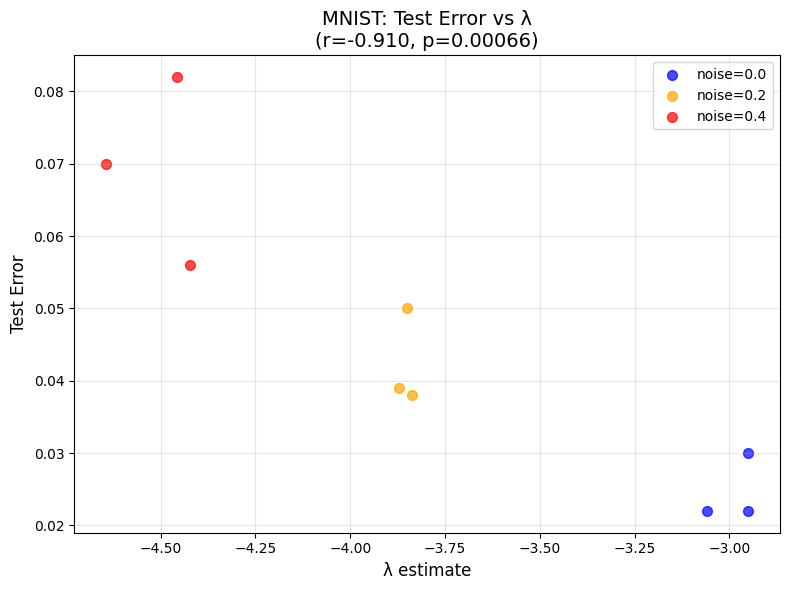


[2/4] Running training dynamics...

MNIST Experiment 3: Training Dynamics (tracking λ over 15 epochs)

Baseline (no regularization):
  Epoch  1: acc=0.9070, λ=-4.9309 [BASE]
  Epoch  3: acc=0.9490, λ=-4.7393 [BASE]
  Epoch  6: acc=0.9610, λ=-4.2276 [BASE]
  Epoch  9: acc=0.9640, λ=-4.0747 [BASE]
  Epoch 12: acc=0.9600, λ=-3.8058 [BASE]
  Epoch 15: acc=0.9590, λ=-3.5702 [BASE]

Regularized:
  Epoch  1: acc=0.8860, λ=-4.8730 [REG]
  Epoch  3: acc=0.9510, λ=-4.8351 [REG]
  Epoch  6: acc=0.9590, λ=-4.5468 [REG]
  Epoch  9: acc=0.9610, λ=-4.4441 [REG]
  Epoch 12: acc=0.9610, λ=-4.3727 [REG]
  Epoch 15: acc=0.9650, λ=-4.3917 [REG]


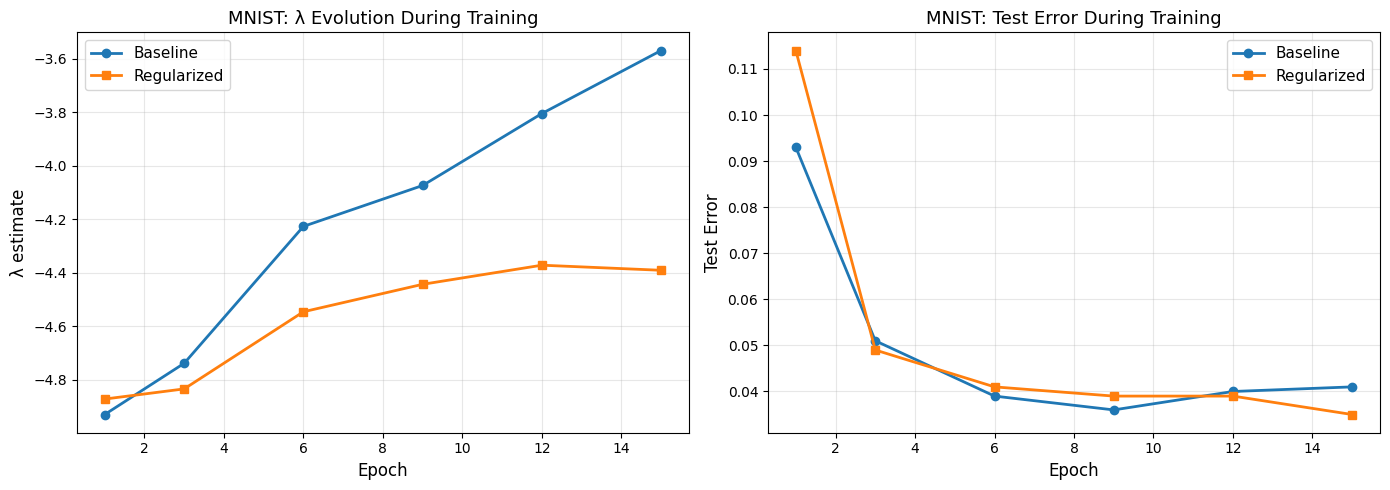


[3/4] Running comprehensive regularization sweep (clean MNIST)...
This generates the results for Section 5.3 'Practical Effects of Global CRR'

MNIST Experiment: Comprehensive Regularization Sweep
Label noise: 0.00
Scales: [0.0, 0.01, 0.1, 1, 10, 100, 200]
Seeds per scale: 5
Comprehensive evaluation: True

Testing scale=0.0000

  Seed 1/5:
    Training... Epoch 2/15: train_loss=0.2919, test_acc=0.9460
Epoch 4/15: train_loss=0.1491, test_acc=0.9650
Epoch 6/15: train_loss=0.1116, test_acc=0.9670
Epoch 8/15: train_loss=0.0779, test_acc=0.9660
Epoch 10/15: train_loss=0.0621, test_acc=0.9700
Epoch 12/15: train_loss=0.0497, test_acc=0.9720
Epoch 14/15: train_loss=0.0462, test_acc=0.9690
acc=0.9740
    Measuring global λ... λ=-2.593
    Computing ECE... 0.0159
    Computing hard sample accuracy... 0.8750
    Computing confusion matrix...
      4/9: 0.0056, 3/8: 0.0000, 6/7: 0.0000
    Measuring class-pair λ values...
      λ(4/9)=-3.710, λ(3/8)=-3.361, λ(6/7)=-2.887
    ✓ Complete

  Seed 2/

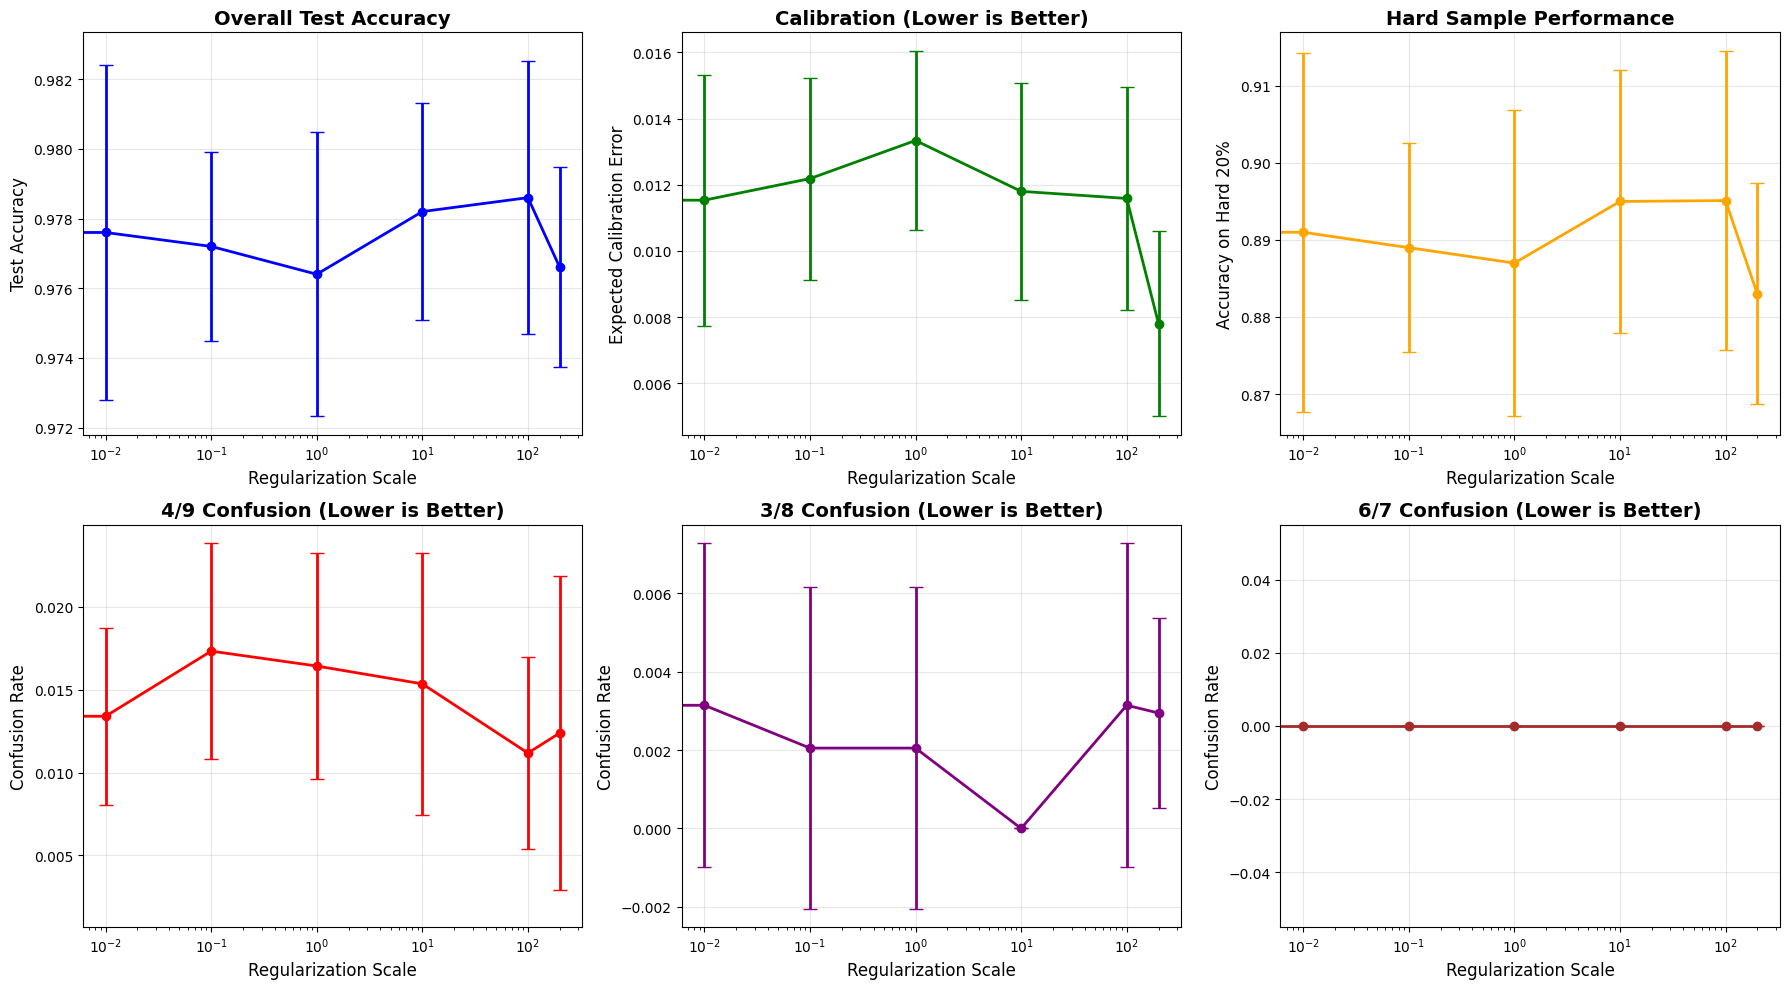


[4/4] Running nth order effect regularization sweep (20% Label Noise)...

MULTI-SCALE, MULTI-SEED N-TH ORDER EXPERIMENT
Configurations: 4
Scales: [1.0, 100.0, 200.0]
Seeds: [42, 123, 456]
Total runs: 36
Label noise: 0.2, Epochs: 30

Configuration: 2nd-4th (orders 2-4)

  Scale 1.0:
    Seed 42 (1/36)... Acc=0.951, ECE=0.071, λ=-2.56
    Seed 123 (2/36)... Acc=0.950, ECE=0.111, λ=-2.73
    Seed 456 (3/36)... Acc=0.946, ECE=0.073, λ=-2.53

  Scale 100.0:
    Seed 42 (4/36)... Acc=0.944, ECE=0.067, λ=-2.65
    Seed 123 (5/36)... Acc=0.952, ECE=0.102, λ=-2.72
    Seed 456 (6/36)... Acc=0.948, ECE=0.079, λ=-2.62

  Scale 200.0:
    Seed 42 (7/36)... Acc=0.942, ECE=0.066, λ=-2.68
    Seed 123 (8/36)... Acc=0.945, ECE=0.102, λ=-2.78
    Seed 456 (9/36)... Acc=0.951, ECE=0.081, λ=-2.66

Configuration: 1st-4th (full) (orders 1-4)

  Scale 1.0:
    Seed 42 (10/36)... Acc=0.947, ECE=0.073, λ=-2.62
    Seed 123 (11/36)... Acc=0.940, ECE=0.098, λ=-2.71
    Seed 456 (12/36)... Acc=0.936, ECE=0.075,

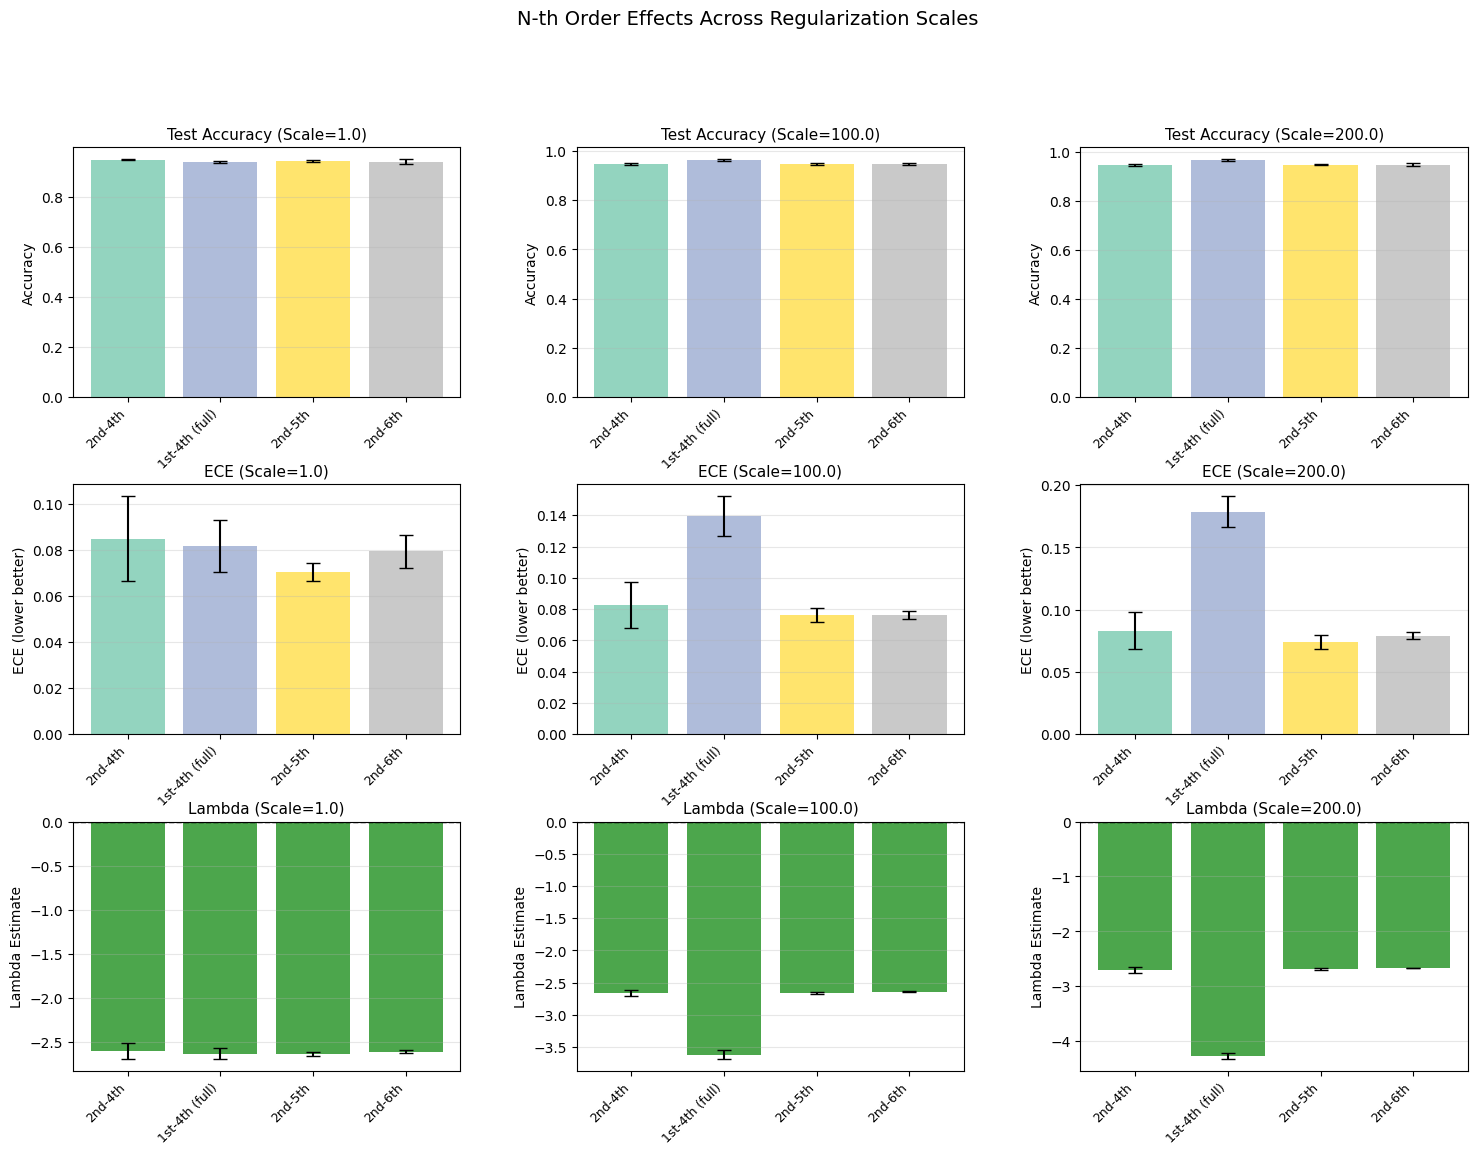


COMPREHENSIVE SUMMARY (Mean ± Std across seeds)

────────────────────────────────────────────────────────────────────────────────────────────────────
SCALE = 1.0
────────────────────────────────────────────────────────────────────────────────────────────────────
Configuration        |        Accuracy |             ECE |        Hard Acc |          Lambda
────────────────────────────────────────────────────────────────────────────────────────────────────
2nd-4th              | 0.9490 ± 0.0022 | 0.0848 ± 0.0185 | 0.8067 ± 0.0062 |  -2.61 ±  0.09
1st-4th (full)       | 0.9410 ± 0.0045 | 0.0817 ± 0.0112 | 0.7667 ± 0.0103 |  -2.63 ±  0.06
2nd-5th              | 0.9427 ± 0.0033 | 0.0706 ± 0.0040 | 0.7667 ± 0.0094 |  -2.64 ±  0.02
2nd-6th              | 0.9413 ± 0.0096 | 0.0795 ± 0.0072 | 0.7767 ± 0.0473 |  -2.61 ±  0.02

────────────────────────────────────────────────────────────────────────────────────────────────────
SCALE = 100.0
──────────────────────────────────────────────────────────

In [14]:
results_with_fix = run_mnist_suite()


MNIST λ ANALYSIS: COMPLETE EXPERIMENTAL SUITE

Device: cuda
This will take significant time due to derivative computations...

[1/4] Running correlation analysis...

MNIST Experiment 1: Correlation Analysis

Testing label_noise=0.00
  Seed 1/3... Epoch 2/10: train_loss=0.2919, test_acc=0.9460
Epoch 4/10: train_loss=0.1491, test_acc=0.9650
Epoch 6/10: train_loss=0.1116, test_acc=0.9670
Epoch 8/10: train_loss=0.0779, test_acc=0.9660
Epoch 10/10: train_loss=0.0621, test_acc=0.9700
acc=0.970, λ=-2.951
  Seed 2/3... Epoch 2/10: train_loss=0.3364, test_acc=0.9460
Epoch 4/10: train_loss=0.1769, test_acc=0.9660
Epoch 6/10: train_loss=0.1217, test_acc=0.9770
Epoch 8/10: train_loss=0.0922, test_acc=0.9740
Epoch 10/10: train_loss=0.0800, test_acc=0.9780
acc=0.978, λ=-3.058
  Seed 3/3... Epoch 2/10: train_loss=0.3140, test_acc=0.9530
Epoch 4/10: train_loss=0.1560, test_acc=0.9720
Epoch 6/10: train_loss=0.1060, test_acc=0.9760
Epoch 8/10: train_loss=0.0777, test_acc=0.9790
Epoch 10/10: train_loss=

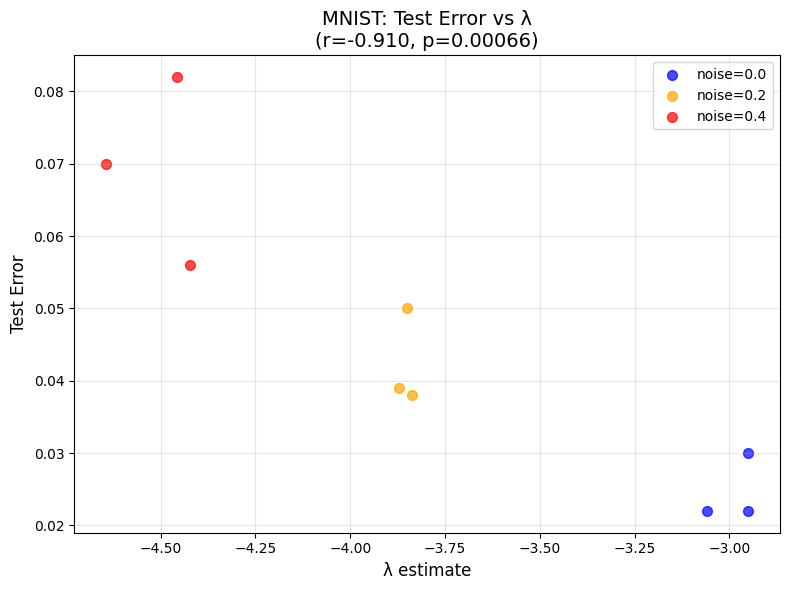


[2/4] Running training dynamics...

MNIST Experiment 3: Training Dynamics (tracking λ over 15 epochs)

Baseline (no regularization):
  Epoch  1: acc=0.9070, λ=-4.9309 [BASE]
  Epoch  3: acc=0.9490, λ=-4.7393 [BASE]
  Epoch  6: acc=0.9610, λ=-4.2276 [BASE]
  Epoch  9: acc=0.9640, λ=-4.0747 [BASE]
  Epoch 12: acc=0.9600, λ=-3.8058 [BASE]
  Epoch 15: acc=0.9590, λ=-3.5702 [BASE]

Regularized:
  Epoch  1: acc=0.8890, λ=-5.0734 [REG]
  Epoch  3: acc=0.9270, λ=-4.8365 [REG]
  Epoch  6: acc=0.9510, λ=-4.5692 [REG]
  Epoch  9: acc=0.9580, λ=-4.5842 [REG]
  Epoch 12: acc=0.9570, λ=-4.5460 [REG]
  Epoch 15: acc=0.9590, λ=-4.6341 [REG]


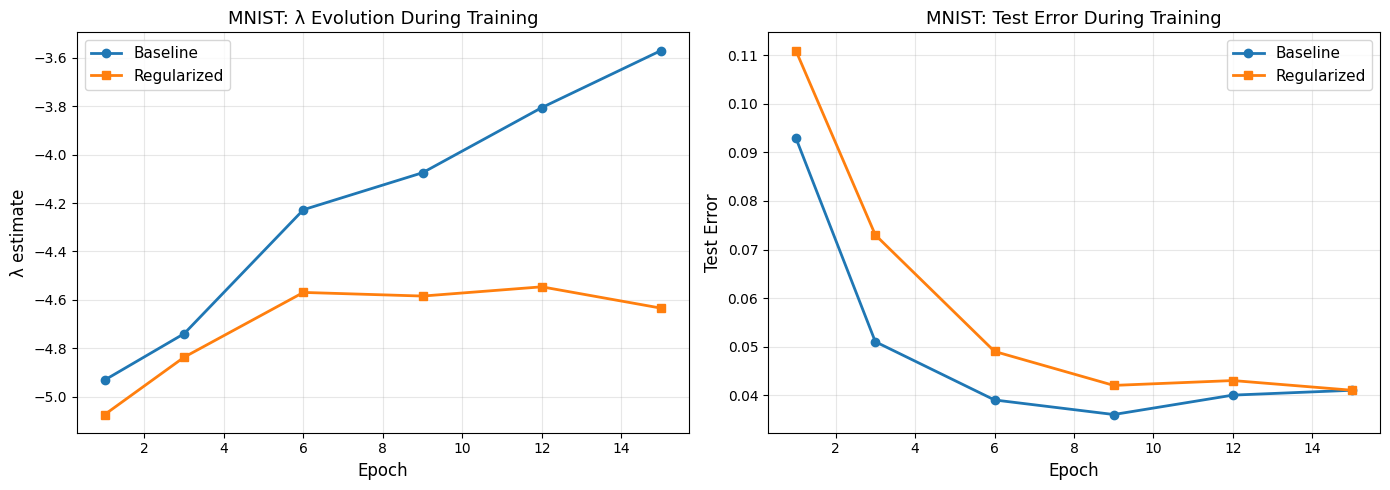


[3/4] Running comprehensive regularization sweep (clean MNIST)...
This generates the results for Section 5.3 'Practical Effects of Global CRR'

MNIST Experiment: Comprehensive Regularization Sweep
Label noise: 0.00
Scales: [0.0, 0.01, 0.1, 1, 10, 100, 200]
Seeds per scale: 5
Comprehensive evaluation: True

Testing scale=0.0000

  Seed 1/5:
    Training... Epoch 2/15: train_loss=0.2919, test_acc=0.9460
Epoch 4/15: train_loss=0.1491, test_acc=0.9650
Epoch 6/15: train_loss=0.1116, test_acc=0.9670
Epoch 8/15: train_loss=0.0779, test_acc=0.9660
Epoch 10/15: train_loss=0.0621, test_acc=0.9700
Epoch 12/15: train_loss=0.0497, test_acc=0.9720
Epoch 14/15: train_loss=0.0462, test_acc=0.9690
acc=0.9740
    Measuring global λ... λ=-2.593
    Computing ECE... 0.0159
    Computing hard sample accuracy... 0.8750
    Computing confusion matrix...
      4/9: 0.0056, 3/8: 0.0000, 6/7: 0.0000
    Measuring class-pair λ values...
      λ(4/9)=-3.710, λ(3/8)=-3.361, λ(6/7)=-2.887
    ✓ Complete

  Seed 2/

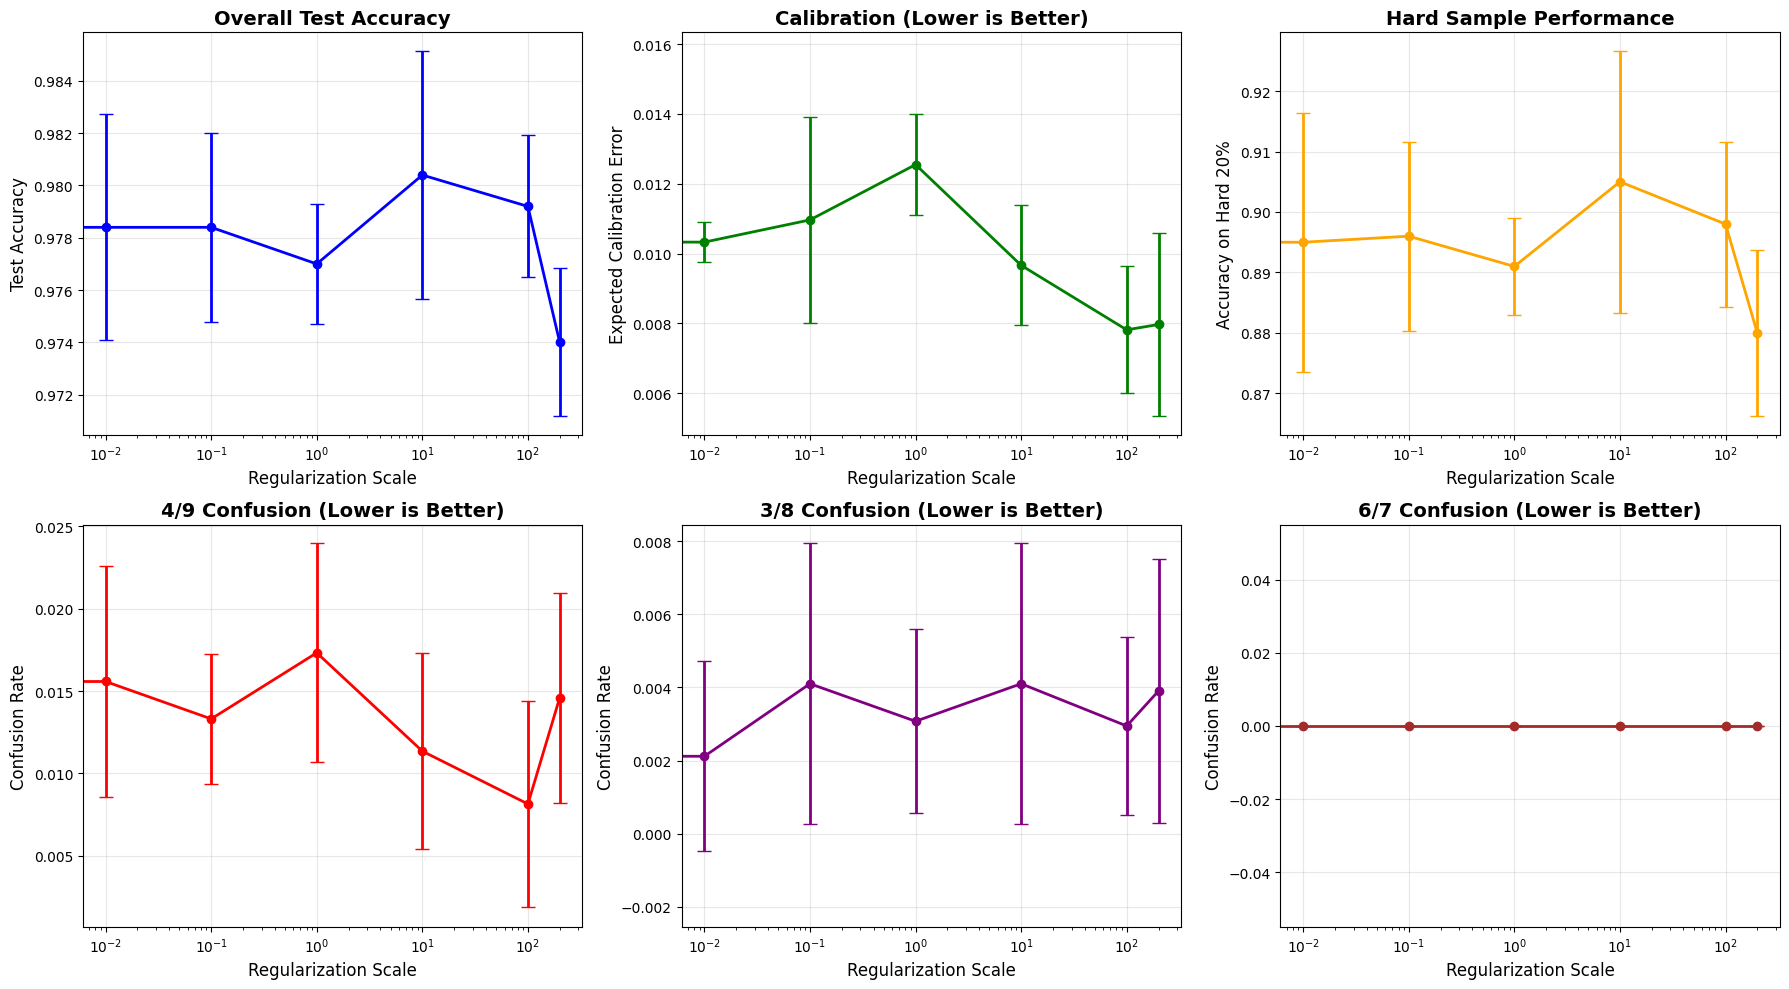


MNIST SUITE COMPLETE
Total time: 17.6 minutes


In [ ]:
results = run_mnist_suite()


[4/4] Running nth order effect regularization sweep (20% Label Noise)...

MULTI-SCALE, MULTI-SEED N-TH ORDER EXPERIMENT
Configurations: 5
Scales: [1.0, 100.0, 200.0]
Seeds: [42, 123, 456]
Total runs: 45
Label noise: 0.2, Epochs: 30

Configuration: 1st only (orders 1-1)

  Scale 1.0:
    Seed 42 (1/45)... Acc=0.949, ECE=0.079, λ=-2.71
    Seed 123 (2/45)... Acc=0.945, ECE=0.081, λ=-2.73
    Seed 456 (3/45)... Acc=0.941, ECE=0.093, λ=-2.73

  Scale 100.0:
    Seed 42 (4/45)... Acc=0.943, ECE=0.269, λ=-5.03
    Seed 123 (5/45)... Acc=0.957, ECE=0.297, λ=-5.00
    Seed 456 (6/45)... Acc=0.951, ECE=0.285, λ=-4.94

  Scale 200.0:
    Seed 42 (7/45)... Acc=0.910, ECE=0.455, λ=-5.51
    Seed 123 (8/45)... Acc=0.897, ECE=0.411, λ=-5.36
    Seed 456 (9/45)... Acc=0.874, ECE=0.420, λ=-5.59

Configuration: 2nd only (orders 2-2)

  Scale 1.0:
    Seed 42 (10/45)... Acc=0.954, ECE=0.092, λ=-2.69
    Seed 123 (11/45)... Acc=0.947, ECE=0.103, λ=-2.70
    Seed 456 (12/45)... Acc=0.949, ECE=0.089, λ=-2

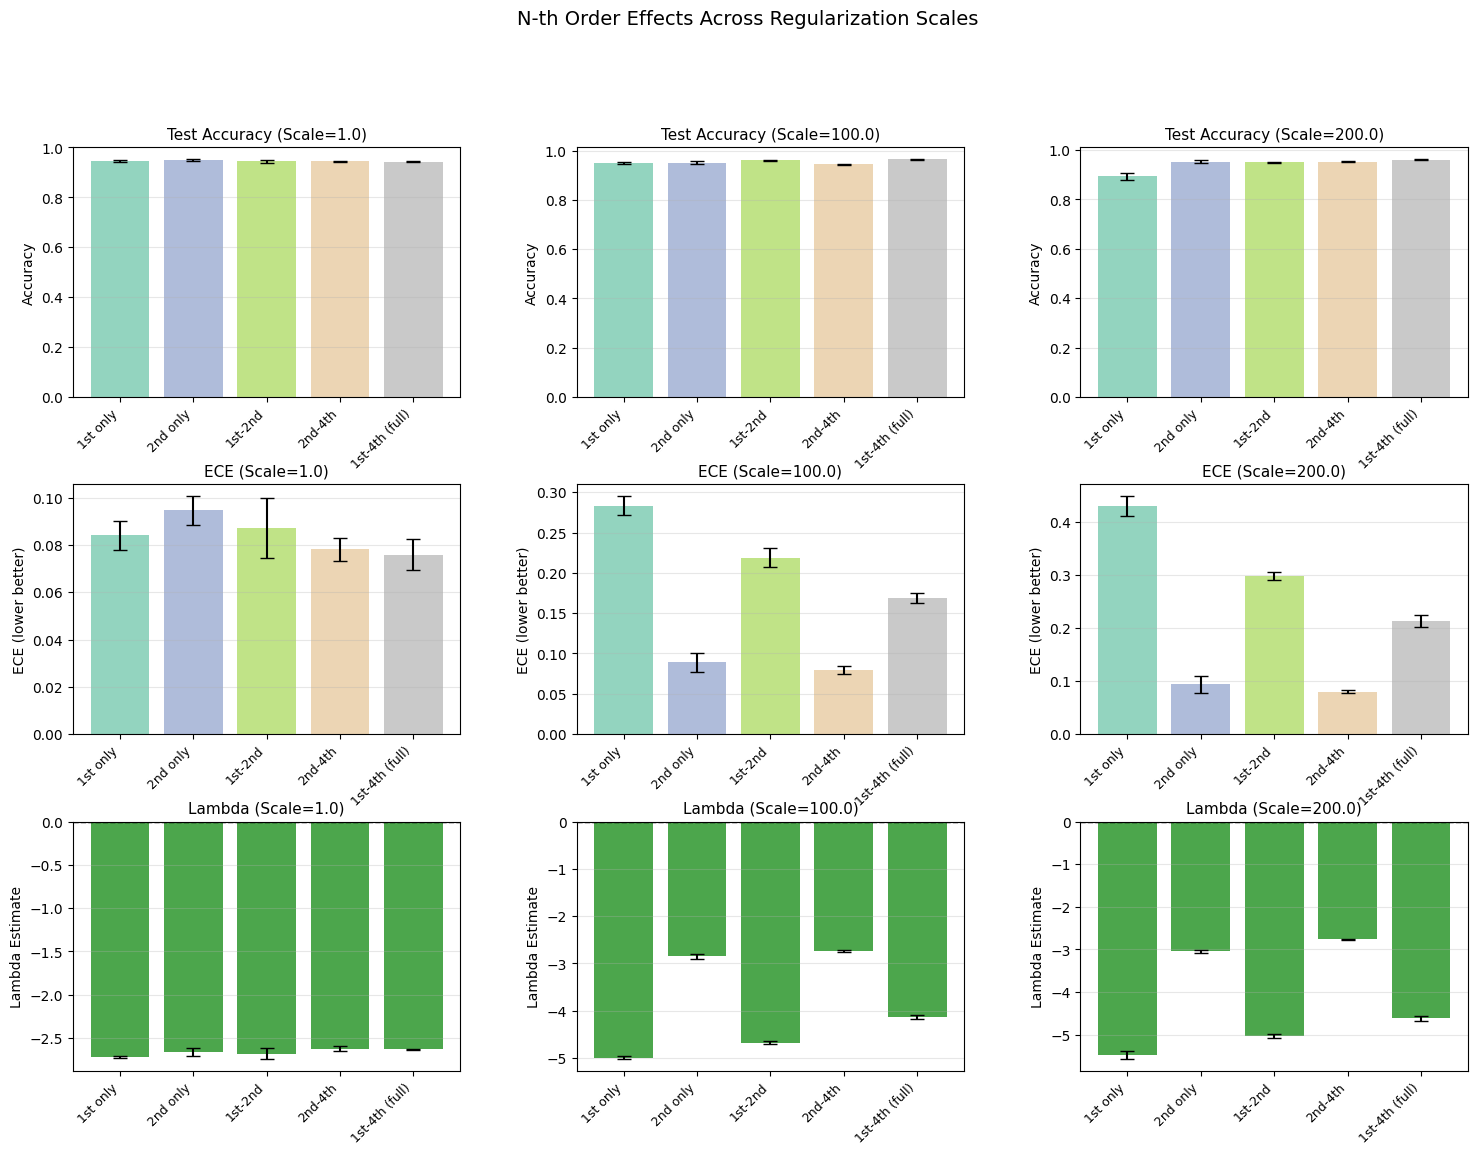


COMPREHENSIVE SUMMARY (Mean ± Std across seeds)

────────────────────────────────────────────────────────────────────────────────────────────────────
SCALE = 1.0
────────────────────────────────────────────────────────────────────────────────────────────────────
Configuration        |        Accuracy |             ECE |        Hard Acc |          Lambda
────────────────────────────────────────────────────────────────────────────────────────────────────
1st only             | 0.9450 ± 0.0033 | 0.0840 ± 0.0063 | 0.7917 ± 0.0085 |  -2.72 ±  0.01
2nd only             | 0.9500 ± 0.0029 | 0.0945 ± 0.0060 | 0.8067 ± 0.0085 |  -2.66 ±  0.05
1st-2nd              | 0.9450 ± 0.0057 | 0.0871 ± 0.0127 | 0.7933 ± 0.0193 |  -2.68 ±  0.07
2nd-4th              | 0.9443 ± 0.0026 | 0.0782 ± 0.0049 | 0.7783 ± 0.0118 |  -2.63 ±  0.03
1st-4th (full)       | 0.9433 ± 0.0026 | 0.0758 ± 0.0066 | 0.7750 ± 0.0178 |  -2.63 ±  0.01

─────────────────────────────────────────────────────────────────────────────────

In [ ]:
# Experiment 4: Nth Order Effects
print("\n[4/4] Running nth order effect regularization sweep (20% Label Noise)...")
all_results, aggregated_stats = experiment_nth_order_multi_scale_seed(
    scales=[1.0, 100.0, 200.0],
    seeds=[42, 123, 456],
    epochs=30,
    label_noise=0.2
)